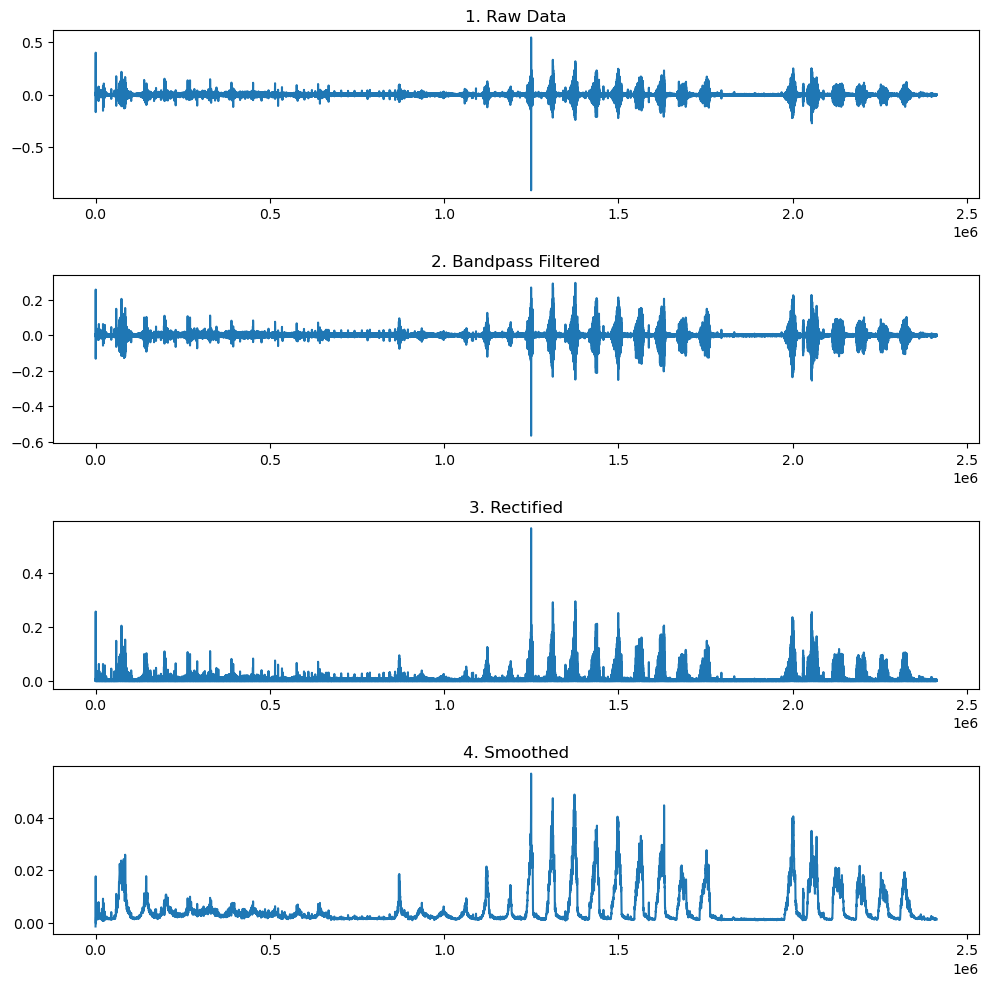

In [22]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# 1. CSV 파일 불러오기 (숫자 데이터만)
data = pd.read_csv('compare.csv', skiprows=6)  # 'EMG 1 (mV)' 다음 줄부터 데이터

# 2. 첫 컬럼만 추출 (예: EMG 1만 존재한다고 가정)
signal_raw = pd.to_numeric(data.iloc[:, 0], errors='coerce').dropna().values

# 3. 샘플링 주파수
Fs = 2148.1481

# 4. 필터 함수 정의
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    return butter(order, [low, high], btype='band')

def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm_cutoff = min(cutoff / nyq, 0.99)
    return butter(order, norm_cutoff, btype='low')

# 5. Bandpass Filter (40–450Hz)
b_bpf, a_bpf = butter_bandpass(40, 450, Fs)
signal_filtered = filtfilt(b_bpf, a_bpf, signal_raw)

# 6. Rectification
signal_rectified = np.abs(signal_filtered)

# 7. Low-pass Filter (3Hz)
b_lpf, a_lpf = butter_lowpass(3, Fs)
signal_smoothed = filtfilt(b_lpf, a_lpf, signal_rectified)

# 8. Plotting
plt.figure(figsize=(10, 12))

plt.subplot(5, 1, 1)
plt.plot(signal_raw)
plt.title("1. Raw Data")

plt.subplot(5, 1, 2)
plt.plot(signal_filtered)
plt.title("2. Bandpass Filtered")

plt.subplot(5, 1, 3)
plt.plot(signal_rectified)
plt.title("3. Rectified")

plt.subplot(5, 1, 4)
plt.plot(signal_smoothed)
plt.title("4. Smoothed")

plt.tight_layout()
plt.show()


In [21]:
import numpy as np
import pandas as pd
from scipy.signal import hilbert

env = signal_smoothed                # 4단계 결과
t = np.arange(len(env)) / Fs         # 시간축 (초)

# 1. 기준선·임계값 잡기 (baseline 0.5초)
baseline = env[:int(0.5*Fs)]
th = baseline.mean() + 3*baseline.std()

# 2. 활성 구간(on/off) 찾기
active = env > th
changes = np.diff(active.astype(int))
onsets  = np.where(changes ==  1)[0]
offsets = np.where(changes == -1)[0]

# 3. 수축별 Feature
features = []
for on, off in zip(onsets, offsets):
    seg = env[on:off]
    features.append({
        'start_s': on/Fs,
        'end_s':   off/Fs,
        'duration_s': (off-on)/Fs,
        'peak': seg.max(),
        'rms': np.sqrt(np.mean(seg**2)),
        'integral': np.trapz(seg, dx=1/Fs)
    })
df_feat = pd.DataFrame(features)
print(df_feat.head())


     start_s      end_s  duration_s      peak       rms  integral
0   6.237466   6.540052    0.302586  0.002124  0.001937  0.000583
1   7.509724  10.100328    2.590604  0.009245  0.004911  0.011680
2  10.158052  16.573345    6.415293  0.041449  0.022443  0.120290
3  16.805173  16.986259    0.181086  0.001753  0.001713  0.000309
4  17.228793  30.089173   12.860380  0.042073  0.021859  0.240770


/tmp/ipykernel_45903/167756237.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'integral': np.trapz(seg, dx=1/Fs)
